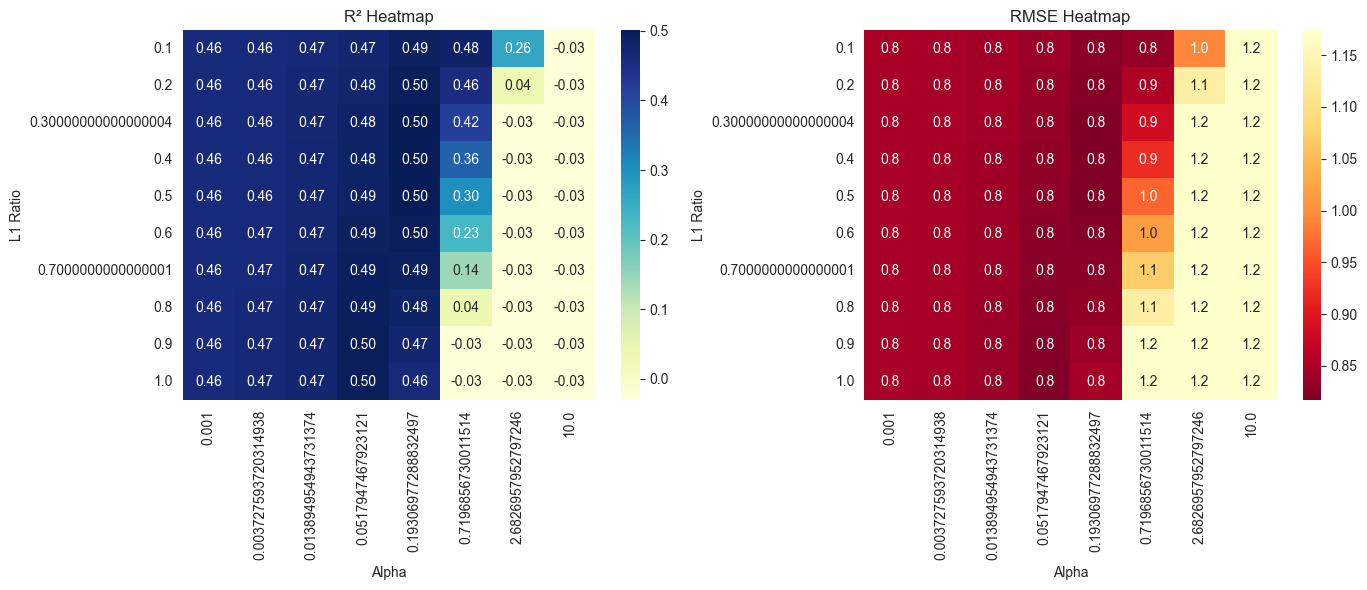

Best ElasticNet configuration:
Alpha: 0.19306977288832497, L1 Ratio: 0.5
R²: 0.501, RMSE: 0.82
                     Feature  Coefficient
7                         ca     0.306848
10           cp_asymptomatic     0.208533
6                    oldpeak     0.205065
21               thal_normal    -0.118776
4                     thalch    -0.095895
5                      exang     0.093952
22    thal_reversable defect     0.075189
19           slope_upsloping    -0.056500
8                 sex_Female    -0.018852
9                   sex_Male     0.018632
15            restecg_normal    -0.016938
14    restecg_lv hypertrophy     0.012045
12            cp_non-anginal    -0.006929
1                   trestbps     0.006221
0                        age     0.000000
3                        fbs     0.000000
2                       chol     0.000000
13         cp_typical angina    -0.000000
11        cp_atypical angina     0.000000
18                slope_flat     0.000000
17         slope_downsl

In [9]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('../DATA/heart_disease_uci(1).csv')

# Preprocessing
# Handle missing values and encode categorical variables
df = df.replace('?', np.nan).dropna()
categorical_cols = ['sex', 'cp', 'restecg', 'slope', 'thal']
df = pd.get_dummies(df, columns=categorical_cols)

# Create binary classification target
df['target'] = (df['num'] > 0).astype(int)

# Split data
X = df.drop(['num', 'target', 'dataset'], axis=1)
y_reg = df['num']
y_clf = df['target']
X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ElasticNet grid search
alphas = np.logspace(-3, 1, 8)
l1_ratios = np.linspace(0.1, 1.0, 10)
results = []

for alpha in alphas:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
        model.fit(X_train_scaled, y_train_reg)  # <-- use y_train_reg
        y_pred = model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))  # <-- use y_test_reg
        r2 = r2_score(y_test_reg, y_pred)                      # <-- use y_test_reg
        results.append({'alpha': alpha, 'l1_ratio': l1_ratio, 'RMSE': rmse, 'R2': r2})

results_df = pd.DataFrame(results)

# Heatmaps
pivot_r2 = results_df.pivot(index='l1_ratio', columns='alpha', values='R2')
pivot_rmse = results_df.pivot(index='l1_ratio', columns='alpha', values='RMSE')

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('R² Heatmap')
plt.xlabel('Alpha')
plt.ylabel('L1 Ratio')

plt.subplot(1,2,2)
sns.heatmap(pivot_rmse, annot=True, fmt=".1f", cmap='YlOrRd_r')
plt.title('RMSE Heatmap')
plt.xlabel('Alpha')
plt.ylabel('L1 Ratio')

plt.tight_layout()
plt.show()

# configuration
best_row = results_df.loc[results_df['R2'].idxmax()]
print("Best ElasticNet configuration:")
print(f"Alpha: {best_row['alpha']}, L1 Ratio: {best_row['l1_ratio']}")
print(f"R²: {best_row['R2']:.3f}, RMSE: {best_row['RMSE']:.2f}")

best_model = ElasticNet(alpha=best_row['alpha'], l1_ratio=best_row['l1_ratio'], max_iter=10000, random_state=42)
best_model.fit(X_train_scaled, y_train_reg)
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_})
print(coef_df.sort_values('Coefficient', key=abs, ascending=False))



Best Logistic Regression configuration:
penalty           l1
solver          saga
accuracy    0.883333
f1          0.857143
auroc       0.942857
auprc       0.944203
Name: 3, dtype: object

Best k-NN configuration:
n_neighbors          10
accuracy       0.883333
f1             0.862745
auroc          0.939429
auprc          0.902088
Name: 2, dtype: object


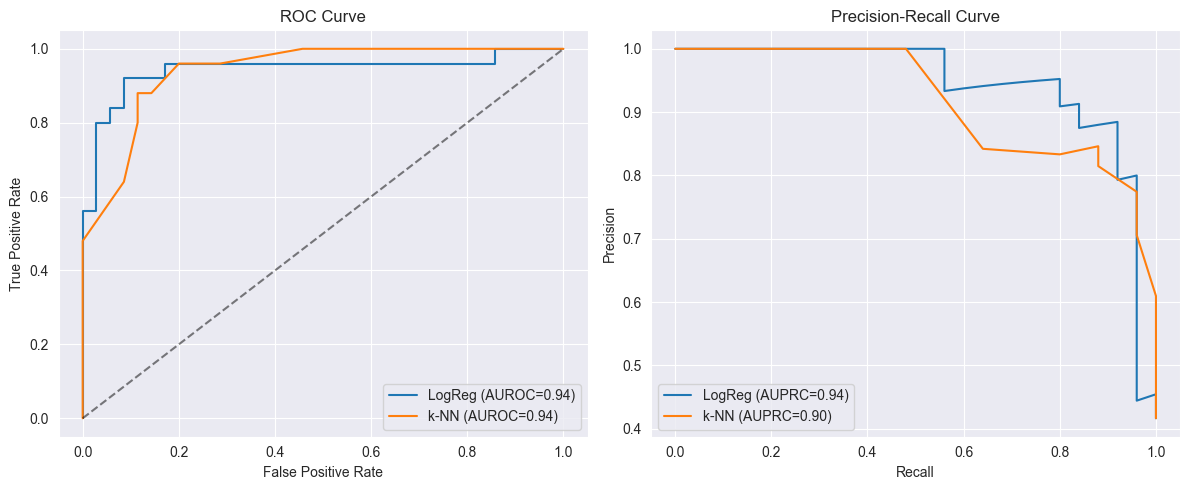

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

# Logistic Regression: Try different penalties and solvers
logreg_results = []
penalties = ['l2', 'l1', 'elasticnet']
solvers = ['liblinear', 'saga']

for penalty in penalties:
    for solver in solvers:
        # Elasticnet only works with saga
        if penalty == 'elasticnet' and solver != 'saga':
            continue
        try:
            clf = LogisticRegression(
                penalty=penalty, solver=solver, l1_ratio=0.5 if penalty == 'elasticnet' else None,
                max_iter=1000
            )
            clf.fit(X_train_scaled, y_train_clf)
            y_pred = clf.predict(X_test_scaled)
            y_prob = clf.predict_proba(X_test_scaled)[:, 1]
            logreg_results.append({
                'penalty': penalty,
                'solver': solver,
                'accuracy': accuracy_score(y_test_clf, y_pred),
                'f1': f1_score(y_test_clf, y_pred),
                'auroc': roc_auc_score(y_test_clf, y_prob),
                'auprc': average_precision_score(y_test_clf, y_prob),
                'model': clf
            })
        except Exception as e:
            print(f"Skipped penalty={penalty}, solver={solver} due to error: {e}")

logreg_df = pd.DataFrame(logreg_results)
best_logreg = logreg_df.sort_values('auroc', ascending=False).iloc[0]
print("\nBest Logistic Regression configuration:")
print(best_logreg[['penalty', 'solver', 'accuracy', 'f1', 'auroc', 'auprc']])

# k-NN: Tune n_neighbors
knn_results = []
for n in [1, 5, 10]:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled, y_train_clf)
    y_pred = knn.predict(X_test_scaled)
    y_prob = knn.predict_proba(X_test_scaled)[:, 1]
    knn_results.append({
        'n_neighbors': n,
        'accuracy': accuracy_score(y_test_clf, y_pred),
        'f1': f1_score(y_test_clf, y_pred),
        'auroc': roc_auc_score(y_test_clf, y_prob),
        'auprc': average_precision_score(y_test_clf, y_prob),
        'model': knn
    })

knn_df = pd.DataFrame(knn_results)
best_knn = knn_df.sort_values('auroc', ascending=False).iloc[0]
print("\nBest k-NN configuration:")
print(best_knn[['n_neighbors', 'accuracy', 'f1', 'auroc', 'auprc']])

# Plot AUROC and AUPRC curves for best models
# Logistic Regression
best_logreg_model = best_logreg['model']
y_prob_logreg = best_logreg_model.predict_proba(X_test_scaled)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_clf, y_prob_logreg)
prec_logreg, rec_logreg, _ = precision_recall_curve(y_test_clf, y_prob_logreg)

# k-NN
best_knn_model = best_knn['model']
y_prob_knn = best_knn_model.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test_clf, y_prob_knn)
prec_knn, rec_knn, _ = precision_recall_curve(y_test_clf, y_prob_knn)

plt.figure(figsize=(12,5))

# AUROC
plt.subplot(1,2,1)
plt.plot(fpr_logreg, tpr_logreg, label=f'LogReg (AUROC={best_logreg["auroc"]:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'k-NN (AUROC={best_knn["auroc"]:.2f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# AUPRC
plt.subplot(1,2,2)
plt.plot(rec_logreg, prec_logreg, label=f'LogReg (AUPRC={best_logreg["auprc"]:.2f})')
plt.plot(rec_knn, prec_knn, label=f'k-NN (AUPRC={best_knn["auprc"]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()
